# Tratamento de Sinais de Áudio
## Aula 16

## Ruído

* Ruídos são variações indesejadas em um sinal;
* Pode ser causado pelo equipamento de gravação, o instrumento ou ruído ambiente;
* Uma sala/estúdio completamente à prova de som terá quase nenhum ruído, enquanto que aquelas próximas de ventiladores, tráfego etc terão mais ruído;
* Ruído branco é um ruído que contém toda frequência na faixa audível em quantidades iguais.

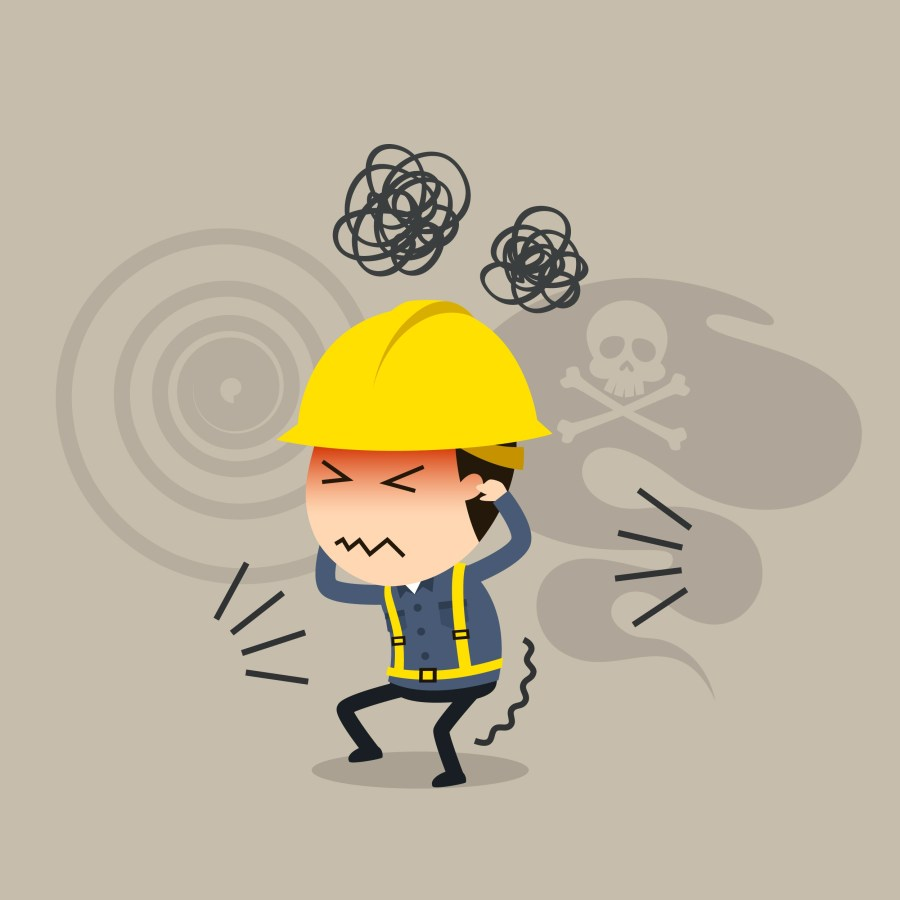

## STFT

* Para a remoção de ruído, costuma-se utilizar  a **Transformada de Fourier de Curto Termo** ([STFT](https://pt.wikipedia.org/wiki/Transformada_de_Fourier_de_curto_termo): *Short Term Fourier Transform*);
* A representação da STFT é em tempo-frequência (TFR: *time-frequency representation*), e não apenas frequência como a Transformada de Fourier.

$$\textbf{STFT}\{x[n]\}(m,\omega)\equiv X(m,\omega)=\sum_{n=-\infty}^\infty x[n]w[n-m]e^{-j\omega n}$$

## Remoção de ruídos

* Para remover o ruído, primeiro transforma-se o sinal usando a STFT;
* Em seguida, utiliza-se uma função de *thresholding* para remover valores muito próximos de zero.

$$S(m,\omega)=\text{STFT}\{x(n)\}\\
S_2(m,\omega)=g(S(m,\omega))\\
g(a)=\begin{cases}
    0, & |a|\leq T\\
    a, & |a| >T\\
\end{cases}$$

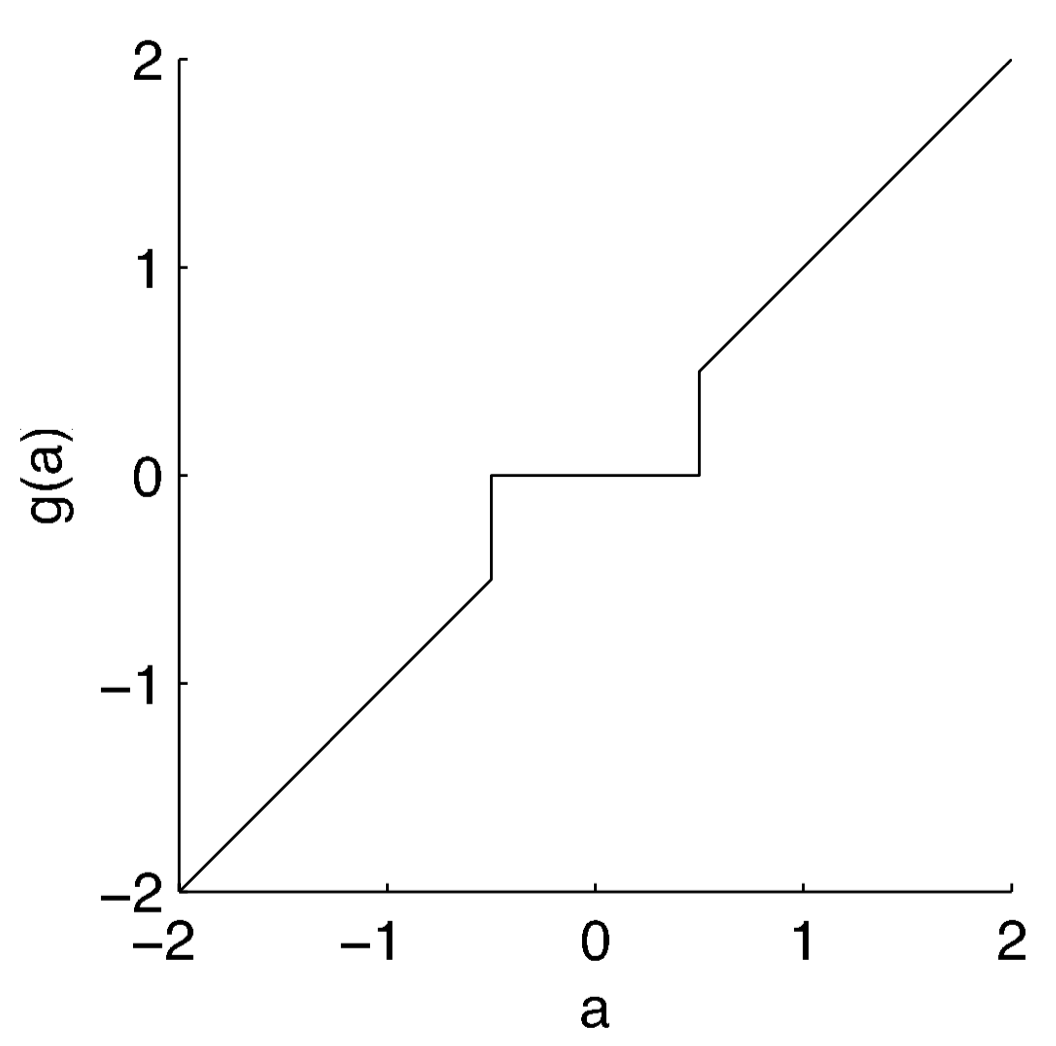

Podemos remover ruídos de um áudio com as funções `stft` e `istft` presentes no módulo `scipy.signal`.

In [5]:
from scipy import signal

Também utilizaremos o `numpy` para manipular arrays:

In [6]:
import numpy as np

Após a transformação com `stft` e *thresholding*, recupera-se o sinal pela transformada inversa `istft`:

In [7]:
def threshold(data, thresh):
    data_abs = np.abs(data)
    data_thresh = np.where(data_abs >= thresh, data, 0)
    return data_thresh

# Parâmetros retirados de:
# https://www.mathworks.com/help/signal/ref/istft.html
def denoise(data, fs, thresh):
    nperseg=120
    win = signal.hamming(nperseg)
    noverlap = 80
    
    fftlen = 512
    # _ ignora o retorno.
    _, _, Zxx = signal.stft(data, fs, window=win, noverlap=noverlap, nfft=fftlen, nperseg=nperseg)
    z_thresh = threshold(Zxx, thresh)
    
    _, x = signal.istft(z_thresh, fs, window=win, noverlap=noverlap, nfft=fftlen, nperseg=nperseg)
    return x

Observações:
* Este processo deve ser aplicado para cada canal de áudio;
* O valor de _threshold_ determina o quanto do ruído será filtrado. Valores muito pequenos não filtrarão bem, porém valores grandes demais podem remover o conteúdo desejado.

* A seguir, podemos ver um sinal de áudio com ruído gaussiano colocado artificialmente;
* A imagem de cima corresponde ao áudio original, a do centro corresponde ao áudio com ruído adicionado artifialmente, e a de baixo ao áudio reconstruído;
* Observe, principalmente, como valores que eram próximos de 0 ficam com amplitude maior.

<table>
    <tr>
        <th>Threshold = 0.001</th>
        <th>Threshold = 0.004</th>
    </tr>
    <tr>
        <td>Threshold foi muito baixo e houve pouca remoção de ruído.</td>
        <td>Threshold adequado.</td>
    </tr>
    <tr>
        <td><img src="attachment:noise_0.001.png" width=600 /></td>
        <td><img src="attachment:noise_0.004.png" width=600 /></td>
    </tr>
</table>
<table>
    <tr>
        <th>Threshold = 0.01</th>
        <th>Threshold = 1</th>
    </tr>
    <tr>
        <td>Threshold alto e cortou parte do áudio que não deveria ter sido removido.</td>
        <td>Threshold muito alto e cortou todo o áudio.</td>
    </tr>
    <tr>
        <td><img src="attachment:noise_0.1.png" width=600 /></td>
        <td><img src="attachment:noise_1.png" width=600 /></td>
    </tr>
</table>

# Exercícios

1. Dado um áudio ruidoso, utilize o processo visto nesta aula para remover ruído e compare o resultado com o áudio original.

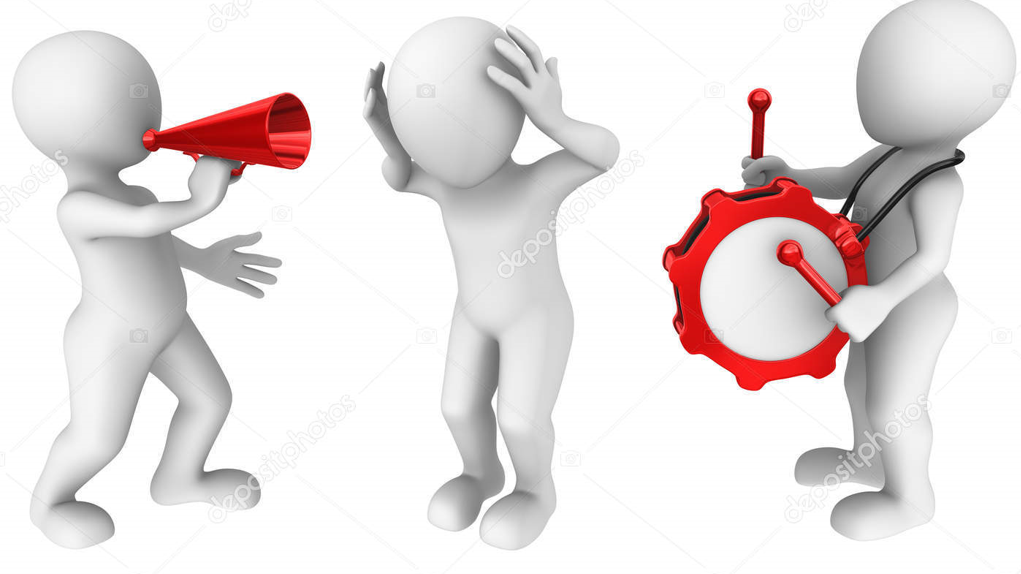

##### Dicas

* Lembre-se de normalizar o áudio para o intervalo entre -1 e 1!
* Para adicionar ruído ao áudio:
```python
nivel_ruido = 0.01
np.random.seed(0) # seed para o gerador aleatório
data_noise = data + np.random.normal(size=data.shape) * nivel_ruido```
* Sua pasta deve conter um áudio de um canal `fish.wav`. Se atente ao `shape` do áudio.
* O áudio pode ser plotado com `plt.plot(meu_audio)`.

In [10]:
import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile

ModuleNotFoundError: No module named 'sounddevice'

In [ ]:
np.random.seed(0)

In [ ]:
def add_noise(data, noise_level):
    noise = np.random.normal(size=data.shape) * noise_level
    return data + noise

In [ ]:
def threshold(data, thresh):
    data_abs = np.abs(data)
    data_thresh = np.where(data_abs >= thresh, data, 0)
    return data_thresh

In [ ]:
def denoise(data, fs, thresh):
    nperseg=120
    win = signal.hamming(nperseg)
    noverlap = 80
    
    fftlen = 512
    # _ ignora o retorno.
    _, _, Zxx = signal.stft(data, fs, window=win, noverlap=noverlap, nfft=fftlen, nperseg=nperseg)
    z_thresh = threshold(Zxx, thresh)
    
    _, x = signal.istft(z_thresh, fs, window=win, noverlap=noverlap, nfft=fftlen, nperseg=nperseg)
    return x

In [ ]:
fs, data_original = wavfile.read('fish.wav')

data_original = data_original.astype(np.float32) / 32767
sd.play(data_original, fs)

In [ ]:
data_noise = add_noise(data_original, 0.01)
sd.play(data_noise, fs)
wavfile.write("audio_ruido.wav", fs, data_noise)

In [ ]:
fs, data = wavfile.read("audio_ruido.wav")

thresh = 0.004
data_denoise = denoise(data, fs, thresh)
sd.play(data_denoise, fs)

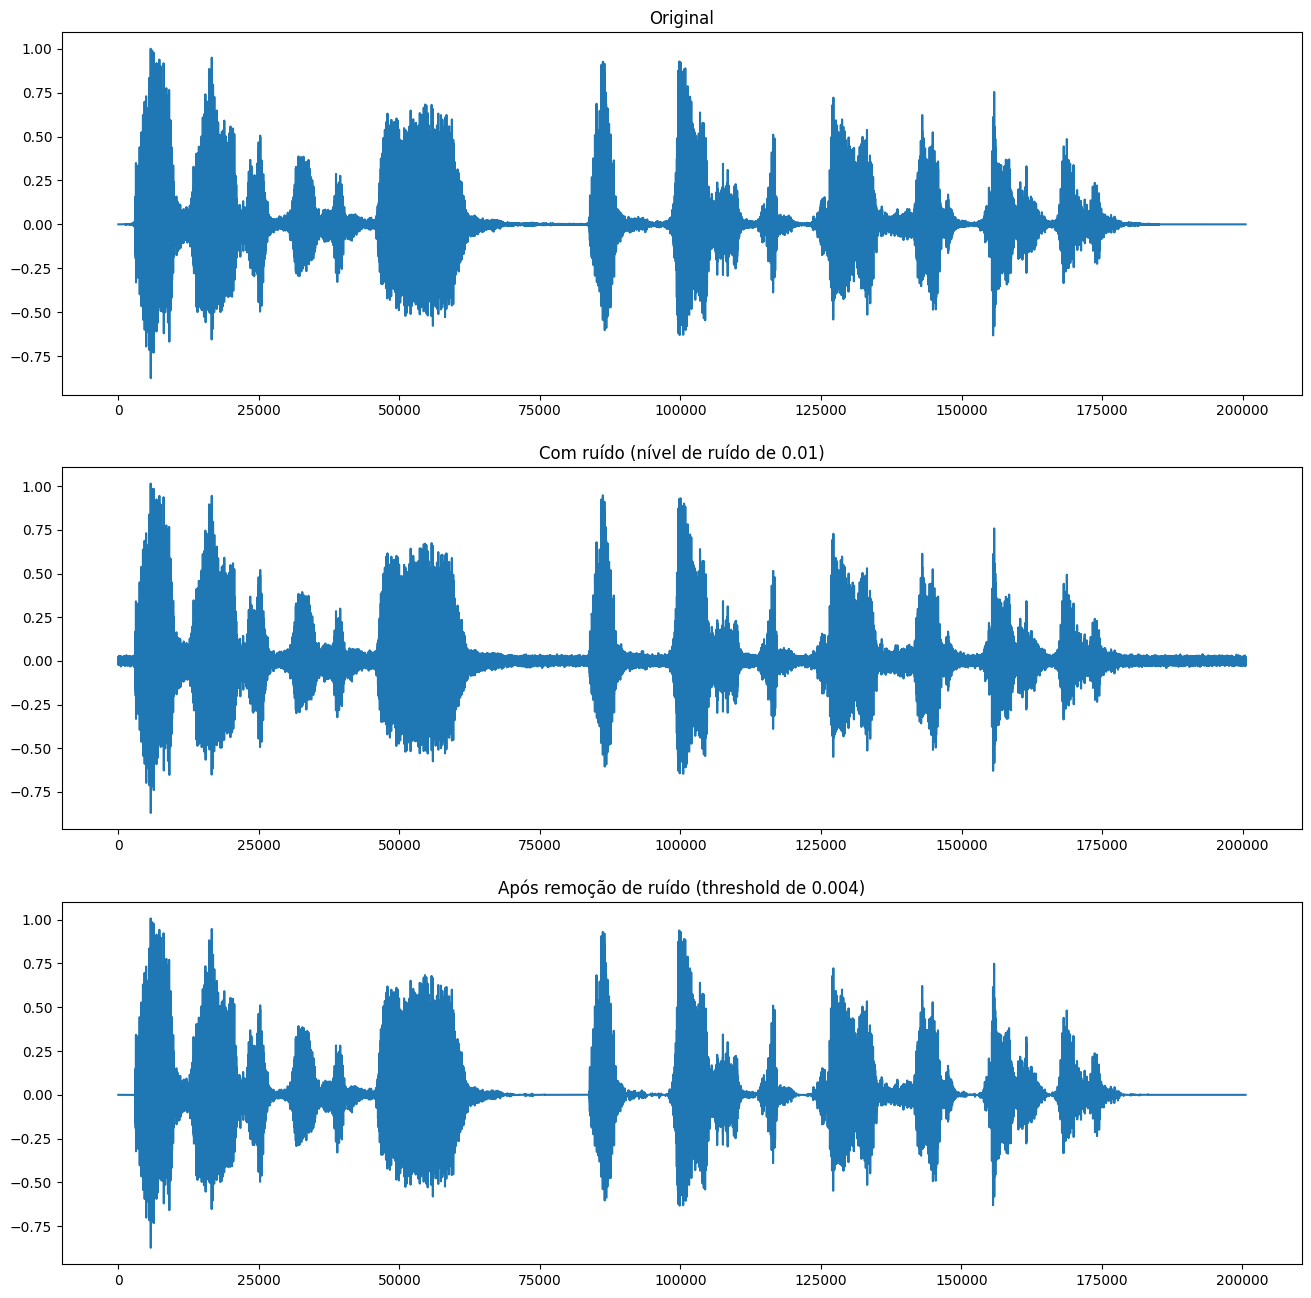

In [ ]:
plt.figure(figsize=(16, 16))

plt.subplot(3, 1, 1)
plt.title("Original")
plt.plot(data_original)

plt.subplot(3, 1, 2)
plt.title("Com ruído (nível de ruído de 0.01)")
plt.plot(data_noise)

plt.subplot(3, 1, 3)
plt.title("Após remoção de ruído (threshold de 0.004)")
plt.plot(data_denoise)

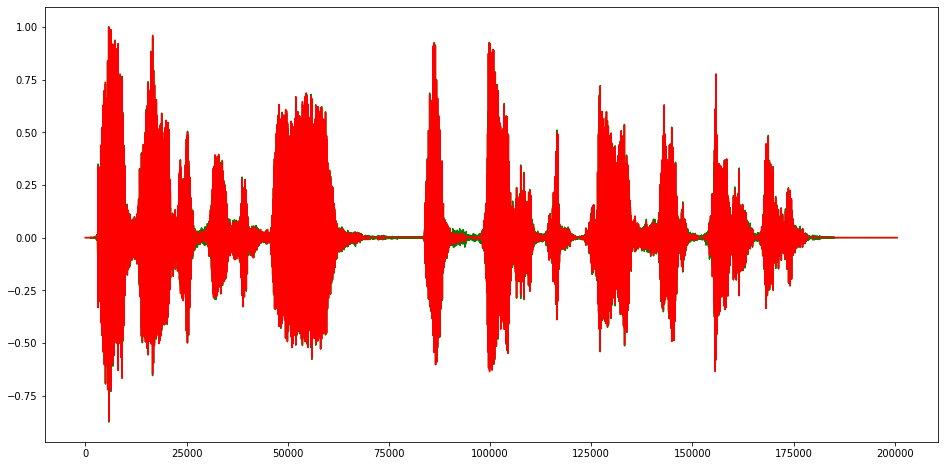

In [ ]:
plt.figure(figsize=(16, 8))

# Verde: Original
plt.plot(data_original, color='green')
# Vermelho: Áudio reconstruído
plt.plot(data_denoise, color='red')

# Referências
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html
* https://timsainburg.com/noise-reduction-python.html
* https://www.mathworks.com/help/signal/ref/istft.html
* https://pt.wikipedia.org/wiki/Transformada_de_Fourier_de_curto_termo

Aula remota, conforme Port. 345/2020 – MEC